In [5]:
import requests
import json

In [7]:
league_id = "992211363579363328"
url = f"https://api.sleeper.app/v1/league/{league_id}/users"

response = requests.get(url)

In [21]:
data = response.json()
data

[{'user_id': '419619117067141120',
  'settings': None,
  'metadata': {'mention_pn': 'on',
   'mascot_message_emotion_leg_10': 'idle',
   'mascot_item_type_id_leg_18': 'pizza',
   'mascot_item_type_id_leg_17': 'pizza',
   'mascot_item_type_id_leg_16': 'pizza',
   'mascot_item_type_id_leg_15': 'pizza',
   'mascot_item_type_id_leg_14': 'pizza',
   'mascot_item_type_id_leg_13': 'pizza',
   'mascot_item_type_id_leg_12': 'pizza',
   'mascot_item_type_id_leg_11': 'pizza',
   'mascot_item_type_id_leg_10': 'pizza',
   'allow_pn': 'on'},
  'league_id': '992211363579363328',
  'is_owner': False,
  'is_bot': False,
  'display_name': 'TheWetCookie',
  'avatar': '87e4024cae674468adaa3cd9327fca68'},
 {'user_id': '467718102394597376',
  'settings': None,
  'metadata': {'mention_pn': 'on',
   'mascot_message_emotion_leg_5': 'taunting',
   'mascot_message_emotion_leg_1': 'idle',
   'mascot_item_type_id_leg_9': 'furrari',
   'mascot_item_type_id_leg_8': 'furrari',
   'mascot_item_type_id_leg_7': 'furrari

In [6]:
import pandas as pd

pd.read_json(data)

NameError: name 'data' is not defined

In [22]:
for item in data:
    del item["metadata"]

In [29]:
pd.read_json(json.dumps(data))

,user_id,settings,league_id,is_owner,is_bot,display_name,avatar
0,419619117067141120,NaN,992211363579363328,False,False,TheWetCookie,87e4024cae674468adaa3cd9327fca68
1,467718102394597376,NaN,992211363579363328,True,False,notnickwright,3849eff2b0923224ae851062a6f66b0c
2,467724601913241600,NaN,992211363579363328,False,False,ADSkinher,17a9d4efd6fc0acf39c53f9c1900dff9
3,467739982753165312,NaN,992211363579363328,False,False,jboyfresh,50ba16db60e2e064b58bc354ce163ddd
4,467844003077812224,NaN,992211363579363328,False,False,fakelymistakely,634a609edec6356659c01d1b65620bf9
5,467860779001966592,NaN,992211363579363328,False,False,30feralhogs,59fb1149ad4ecdc6b96a2feead3a07c1
6,574000543068106752,NaN,992211363579363328,False,False,Giants6and1,81dbc946fb05c852df87d5650e0e26d5
7,602280605933178880,NaN,992211363579363328,False,False,Dens1girl,db780845820808ef24d8766eae8fffdf
8,602553278961614848,NaN,992211363579363328,False,False,kimfused,8aafd2e52c63ca0a4e994c9059fd8418
9,728396625118097408,NaN,992211363579363328,False,False,DownfieldDaks,9b8f723e5213999dc0115d0ccc05edee


In [1]:
import pandas as pd
from pandas import json_normalize
import psycopg2
import requests
import json
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def execute_statement(sql: str):
    with psycopg2.connect(
        host="localhost", database="thefantasybot", user="tbakely"
    ) as conn:
        df = pd.read_sql(sql, conn)
        return df

class SleeperLeague:
    # remember to incorporate json_normalize when rosters are set
    def __init__(self, league_id: int, year: int = None, json: bool = False, dynasty=False):
        self.league_id = str(league_id)
        self.year = year
        self.json = json
        self.dynasty = dynasty
        self.sleeper_ids = execute_statement("select sleeper_id as id, name from full_ids")
        self.sleeper_ids["id"] = self.sleeper_ids["id"].astype(str).apply(lambda x: x[:-2])


    def get_data(self, url):
        response = requests.get(url)
        if not self.json:
            data = json.dumps(response.json())
            return pd.read_json(data)
        else:
            return response.json()
    
    def users(self):
        url = f"https://api.sleeper.app/v1/league/{self.league_id}/users"
        users = self.get_data(url)
        users = pd.concat([users, json_normalize(users["metadata"])], axis=1).drop(columns="metadata")
        return users
    
    def rosters(self):
        url = f"https://api.sleeper.app/v1/league/{self.league_id}/rosters"
        rosters = self.get_data(url)
        rosters = pd.concat([rosters, json_normalize(rosters["metadata"])], axis=1).drop(columns="metadata")
        temp = json_normalize(rosters["settings"])
        rosters = pd.concat([rosters, temp], axis=1).drop("settings", axis=1)

        sleeper_ids_dict = self.sleeper_ids[["id", "name"]].set_index("id").to_dict()["name"]

        df_rows = []
        if self.dynasty:
            rosters["starters_mapped"] = rosters["starters"].apply(lambda x: [sleeper_ids_dict[k] for k in x])
            start_positions = ["QB", "RB1", "RB2", "WR1", "WR2", "WR3", "TE", "FLEX1", "FLEX2", "SFLEX"]
        else:
            rosters["starters_mapped"] = rosters["starters"].apply(lambda x: [sleeper_ids_dict[k] if not len(k) < 4 else k for k in x])
            start_positions = ["QB", "RB1", "RB2", "WR1", "WR2", "TE", "FLEX1", "FLEX2", "FLEX3", "DEF"]
        for i, row in enumerate(rosters["starters_mapped"]):
            data = dict(zip(start_positions, row))
            df = pd.DataFrame(data, index=[i])
            df_rows.append(df)
        temp = pd.concat(df_rows)
        rosters = pd.concat([rosters, temp], axis=1)

        return rosters

    def draft(self, draft_id):
        url = f"https://api.sleeper.app/v1/draft/{draft_id}/picks"
        draft = self.get_data(url)
        draft = pd.concat([draft, json_normalize(draft["metadata"])], axis=1).drop(columns="metadata")
        draft["player_name"] = draft["first_name"] + " " + draft["last_name"]
        draft.drop(columns=["first_name", "last_name"], inplace=True)
        return draft

    def weekly_report(self, position: str):
        roster = self.rosters()
        not_available = list(roster["players"].explode())
        if self.year is None:
            weekly_data = execute_statement(f"select * from weekly_{position}")
        else:
            weekly_data = execute_statement(f"select * from weekly_{position} where season = {self.year}")
        weekly_data["available"] = np.where(weekly_data["sleeper_id"].astype(int).astype(str).isin(not_available), 0, 1)
        return weekly_data.drop_duplicates()
        


In [18]:
nick_league = SleeperLeague(league_id=992211363579363328, year=2022)

In [19]:
nick_league.weekly_report("QB")


,player_id,sleeper_id,player_name,position,recent_team,season,week,comp_pct,passing_yards,passing_tds,...,total_usage,roof,surface,weather_hazards,temp,humidity,wind_speed,total_blitz,blitz_faced_pct,available
0,00-0019596,167.0,T.Brady,QB,TB,2022,1,0.67,212.0,1,...,29.0,closed,matrixturf,NONE,NaN,NaN,NaN,4.0,0.064516,1
1,00-0019596,167.0,T.Brady,QB,TB,2022,2,0.53,190.0,1,...,37.0,dome,sportturf,NONE,85.0,0.68,5.0,5.0,0.074627,1
2,00-0019596,167.0,T.Brady,QB,TB,2022,3,0.74,271.0,1,...,43.0,outdoors,grass,NONE,88.0,0.58,5.0,19.0,0.292308,1
3,00-0019596,167.0,T.Brady,QB,TB,2022,4,0.75,385.0,3,...,52.0,outdoors,grass,NONE,75.0,0.59,7.0,13.0,0.203125,1
4,00-0019596,167.0,T.Brady,QB,TB,2022,5,0.67,351.0,1,...,55.0,outdoors,grass,NONE,83.0,0.57,8.0,6.0,0.075949,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,00-0038122,8159.0,D.Ridder,QB,ATL,2022,16,0.67,218.0,0,...,37.0,outdoors,grass,COLD,17.0,0.39,16.0,11.0,0.154930,1
578,00-0038122,8159.0,D.Ridder,QB,ATL,2022,17,0.73,169.0,0,...,30.0,closed,fieldturf,NONE,64.0,0.86,6.0,17.0,0.274194,1
579,00-0038122,8159.0,D.Ridder,QB,ATL,2022,18,0.63,224.0,2,...,32.0,closed,fieldturf,RAIN,58.0,0.65,6.0,12.0,0.187500,1
580,00-0038128,8161.0,M.Willis,QB,TEN,2022,9,0.31,80.0,0,...,24.0,outdoors,grass,NONE,58.0,0.40,14.0,7.0,0.137255,1


In [10]:
roster_dict = roster["settings"][:5]

# for key, value in roster_dict.items():
#     roster_dict = 


temp = json_normalize(roster["settings"])
roster = pd.concat([roster, temp], axis=1).drop("settings", axis=1)

df_rows = []
start_positions = ["QB", "RB1", "RB1", "WR1", "WR2", "WR3", "TE", "FLEX1", "FLEX2", "SFLEX"]
for i, row in enumerate(roster["starters"]):
    data = dict(zip(start_positions, row))
    df = pd.DataFrame(data, index=[i])
    df_rows.append(df)
temp = pd.concat(df_rows)
roster = pd.concat([roster, temp], axis=1).drop("starters", axis=1)
roster


NameError: name 'roster' is not defined

In [179]:
pd.set_option('display.max_columns', None)

nick_roster = nick_league.rosters()

In [3]:
from sleeper_config import *
from sleeperapi import SleeperLeague

nick_league = SleeperLeague(**leagues["NICK"])

/Users/tylerbakely/Desktop/repos/NFL-Analysis/sleeperapi.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


In [5]:
nick_league.rosters()

,taxi,starters,roster_id,reserve,players,player_map,owner_id,league_id,keepers,co_owners,wins,waiver_position,waiver_budget_used,total_moves,ties,losses,fpts,starters_mapped,QB,RB1,RB2,WR1,WR2,TE,FLEX1,FLEX2,FLEX3,DEF
0,NaN,"[6804, 4663, 4199, 7526, 5846, 7600, 4983, 237...",1,NaN,"[10225, 2161, 2374, 4199, 4663, 4983, 5846, 68...",NaN,467718102394597376,992211363579363328,NaN,NaN,0,10,0,0,0,0,0,"[Jordan Love, Austin Ekeler, Aaron Jones, Jayl...",Jordan Love,Austin Ekeler,Aaron Jones,Jaylen Waddle,DK Metcalf,Pat Freiermuth,D.J. Moore,Tyler Lockett,Antonio Gibson,DEN
1,NaN,"[6904, 6790, 6151, 1479, 4068, 4066, 4039, 816...",2,NaN,"[1479, 4017, 4029, 4039, 4066, 4068, 4089, 503...",NaN,860017601785466880,992211363579363328,NaN,NaN,0,4,0,0,0,0,0,"[Jalen Hurts, D'Andre Swift, Miles Sanders, Ke...",Jalen Hurts,D'Andre Swift,Miles Sanders,Keenan Allen,Mike Williams,Evan Engram,Cooper Kupp,Skyy Moore,Dalvin Cook,PHI
2,NaN,"[4984, 8129, 7588, 6794, 8144, 2505, 8138, 999...",3,NaN,"[2028, 2505, 4984, 6794, 7588, 7596, 7608, 812...",NaN,419619117067141120,992211363579363328,NaN,NaN,0,12,0,0,0,0,0,"[Josh Allen, Dameon Pierce, Javonte Williams, ...",Josh Allen,Dameon Pierce,Javonte Williams,Justin Jefferson,Chris Olave,Darren Waller,James Cook,Zay Flowers,Khalil Herbert,DAL
3,NaN,"[7591, 9509, 6938, 7547, 7525, 5022, 9488, 694...",4,NaN,"[10229, 1373, 5022, 6826, 6938, 6943, 7525, 75...",NaN,602280605933178880,992211363579363328,NaN,NaN,0,6,0,0,0,0,0,"[Justin Fields, Bijan Robinson, Cam Akers, Amo...",Justin Fields,Bijan Robinson,Cam Akers,Amon-Ra St. Brown,DeVonta Smith,Dallas Goedert,Jaxon Smith-Njigba,Gabriel Davis,Cole Kmet,BUF
4,NaN,"[7523, 9221, 8205, 3321, 2133, 10236, 2309, 22...",5,NaN,"[10236, 1234, 2133, 2216, 2309, 3321, 5890, 75...",NaN,574000543068106752,992211363579363328,NaN,NaN,0,5,0,0,0,0,0,"[Trevor Lawrence, Jahmyr Gibbs, Isiah Pacheco,...",Trevor Lawrence,Jahmyr Gibbs,Isiah Pacheco,Tyreek Hill,Davante Adams,Dalton Kincaid,Amari Cooper,Mike Evans,Jordan Addison,NYG
5,NaN,"[96, 5850, 7611, 2449, 5872, 7553, 8137, 5848,...",6,NaN,"[2449, 3163, 4147, 5045, 5185, 5284, 5848, 585...",NaN,467739982753165312,992211363579363328,NaN,NaN,0,2,0,0,0,0,0,"[96, Josh Jacobs, Rhamondre Stevenson, Stefon ...",96,Josh Jacobs,Rhamondre Stevenson,Stefon Diggs,Deebo Samuel,Kyle Pitts,George Pickens,Marquise Brown,Samaje Perine,MIA
6,NaN,"[9229, 4034, 7528, 8146, 1426, 5001, 6806, 403...",7,NaN,"[10235, 1166, 1426, 4034, 4037, 4985, 5001, 61...",NaN,467724601913241600,992211363579363328,NaN,NaN,0,11,0,0,0,0,0,"[Anthony Richardson, Christian McCaffrey, Naje...",Anthony Richardson,Christian McCaffrey,Najee Harris,Garrett Wilson,DeAndre Hopkins,Dalton Schultz,J.K. Dobbins,Chris Godwin,Quentin Johnston,BAL
7,NaN,"[4881, 4988, 4018, 5859, 8112, 8172, 5927, 681...",8,NaN,"[4018, 4881, 4988, 5859, 5927, 5937, 6819, 756...",NaN,467844003077812224,992211363579363328,NaN,NaN,0,3,0,0,0,0,0,"[Lamar Jackson, Nick Chubb, Joe Mixon, A.J. Br...",Lamar Jackson,Nick Chubb,Joe Mixon,A.J. Brown,Drake London,Greg Dulcich,Terry McLaurin,Michael Pittman,Diontae Johnson,PIT
8,NaN,"[4046, 7543, 8151, 8167, 8119, 1466, 5987, 709...",9,NaN,"[10859, 1466, 1689, 2197, 3294, 4035, 4046, 59...",NaN,467860779001966592,992211363579363328,NaN,NaN,0,7,0,0,0,0,0,"[Patrick Mahomes, Travis Etienne, Kenneth Walk...",Patrick Mahomes,Travis Etienne,Kenneth Walker III,Christian Watson,Jahan Dotson,Travis Kelce,Alexander Mattison,Darnell Mooney,Brandin Cooks,NYJ
9,NaN,"[6768, 3198, 4137, 6786, 4981, 4217, 5892, 682...",10,NaN,"[2078, 2749, 3198, 4040, 4111, 4137, 4217, 498...",NaN,728396625118097408,992211363579363328,NaN,NaN,0,1,0,0,0,0,0,"[Tua Tagovailoa, Derrick Henry, James Conner, ...",Tua Tagovailoa,Derrick Henry,James Conner,CeeDee Lamb,Calvin Ridley,George Kittle,David Montgomery,AJ Dillon,JuJu Smith-Schuster,GB


In [104]:
# no of each position drafted, best value, worst value, average points per team, 

grouped = test_draft[["position", "draft_slot"]].groupby(["position", "draft_slot"], as_index=False).size()
grouped.pivot(index="draft_slot", columns="position", values="size")

position,QB,RB,TE,WR
draft_slot,,,,
1,2,4,1,6
2,4,4,1,4
3,2,4,1,6
4,3,3,1,5
5,2,4,2,4
6,2,3,2,5
7,2,3,2,5
8,2,4,2,4
9,2,4,1,5


In [105]:
# test_draft
pivoted = test_draft.pivot_table(index="draft_slot", columns="position", aggfunc="size", fill_value=0)

In [106]:
pivoted.columns.name = None
pivoted.reset_index(inplace=True)

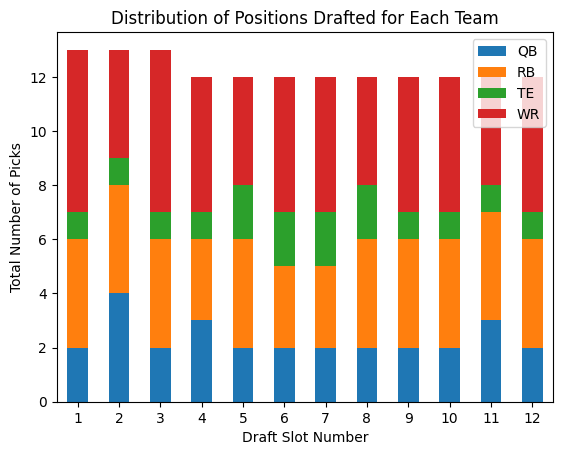

In [107]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)

pivoted.set_index("draft_slot").plot(kind="bar", stacked="True")

plt.title("Distribution of Positions Drafted for Each Team")
plt.xlabel("Draft Slot Number")
plt.ylabel("Total Number of Picks")
plt.xticks(rotation=0)
plt.show()

In [58]:
tiers = pd.read_csv("tiers.csv")
tiers.head()

,Player,Tier
0,Patrick Mahomes,1
1,Josh Allen,1
2,Jalen Hurts,1
3,Lamar Jackson,1
4,Joe Burrow,1


In [59]:
draft_grade = test_draft.merge(tiers, left_on="player_name", right_on="Player", how="left")

In [60]:
draft_grade_final = draft_grade[["draft_slot", "Tier"]].groupby("draft_slot", as_index=False).mean("Tier").sort_values("Tier", ascending=False)

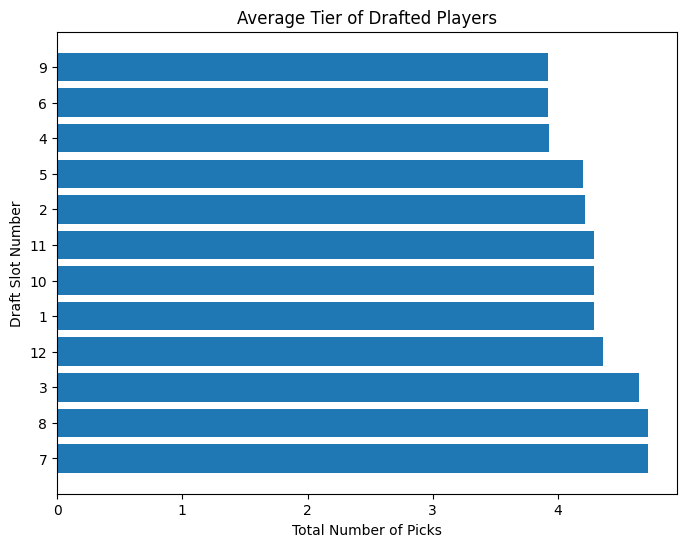

In [63]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)

plt.barh(draft_grade_final["draft_slot"].astype(str).values, draft_grade_final["Tier"])
plt.title("Average Tier of Drafted Players")
plt.ylabel("Draft Slot Number")
plt.xlabel("Total Number of Picks")
plt.show()

In [129]:
draft_grade.loc[draft_grade["Tier"].isnull()]

,round,roster_id,player_id,picked_by,pick_no,is_keeper,draft_slot,draft_id,years_exp,team,status,sport,position,player_id,number,news_updated,injury_status,player_name,Player,Tier


In [57]:
# test_draft_round12 = test_draft.loc[test_draft["round"].astype(int) <= 12]
test_draft

,round,roster_id,player_id,picked_by,pick_no,is_keeper,draft_slot,draft_id,years_exp,team,status,sport,position,player_id,number,news_updated,injury_status,player_name
0,1,3,6794,419619117067141120,1,NaN,1,992211363579363328,3,MIN,Active,nfl,WR,6794,18,1691706922962,,Justin Jefferson
1,1,7,4034,467724601913241600,2,NaN,2,992211363579363328,6,SF,Active,nfl,RB,4034,23,1693078813740,,Christian McCaffrey
2,1,1,4663,467718102394597376,3,NaN,3,992211363579363328,6,LAC,Active,nfl,RB,4663,30,1691888150268,,Austin Ekeler
3,1,12,7564,602553278961614848,4,NaN,4,992211363579363328,2,CIN,Active,nfl,WR,7564,1,1691862347355,,Ja'Marr Chase
4,1,11,4866,992254866238009344,5,NaN,5,992211363579363328,5,NYG,Active,nfl,RB,4866,26,1692426359270,,Saquon Barkley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,15,5,NYG,574000543068106752,176,NaN,8,992211363579363328,,NYG,,nfl,DEF,NYG,,,,New York Giants
176,15,2,7002,860017601785466880,177,NaN,9,992211363579363328,3,NO,Active,nfl,TE,7002,83,1692540915721,,Juwan Johnson
177,15,8,8110,467844003077812224,178,NaN,10,992211363579363328,1,DAL,Active,nfl,TE,8110,87,1692804940914,,Jake Ferguson
178,15,6,5284,467739982753165312,179,NaN,11,992211363579363328,5,MIA,Active,nfl,RB,5284,23,1693086314110,Questionable,Jeff Wilson


In [52]:
import psycopg2

def execute_statement(sql: str):
    with psycopg2.connect(host="localhost", database="thefantasybot", user="tbakely") as conn:
         df = pd.read_sql(sql, conn)
         return df

In [181]:
weekly_qb = execute_statement("select * from weekly_qb where season = 2022 and week = 3")
# sleeper_ids = execute_statement("select sleeper_id as id, name from full_ids")

/var/folders/kd/wsb4g4vj6gx4yk1tp4zdh_h00000gn/T/ipykernel_98875/704659249.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


In [144]:
sleeper_ids["id"] = sleeper_ids["id"].astype(str).apply(lambda x: x[:-2])
sleeper_ids_dict = sleeper_ids[["id", "name"]].set_index("id").to_dict()["name"]
nick_rosters["starters_mapped"] = nick_rosters["starters"].apply(lambda x: [sleeper_ids_dict[k] if not len(k) < 4 else k for k in x])

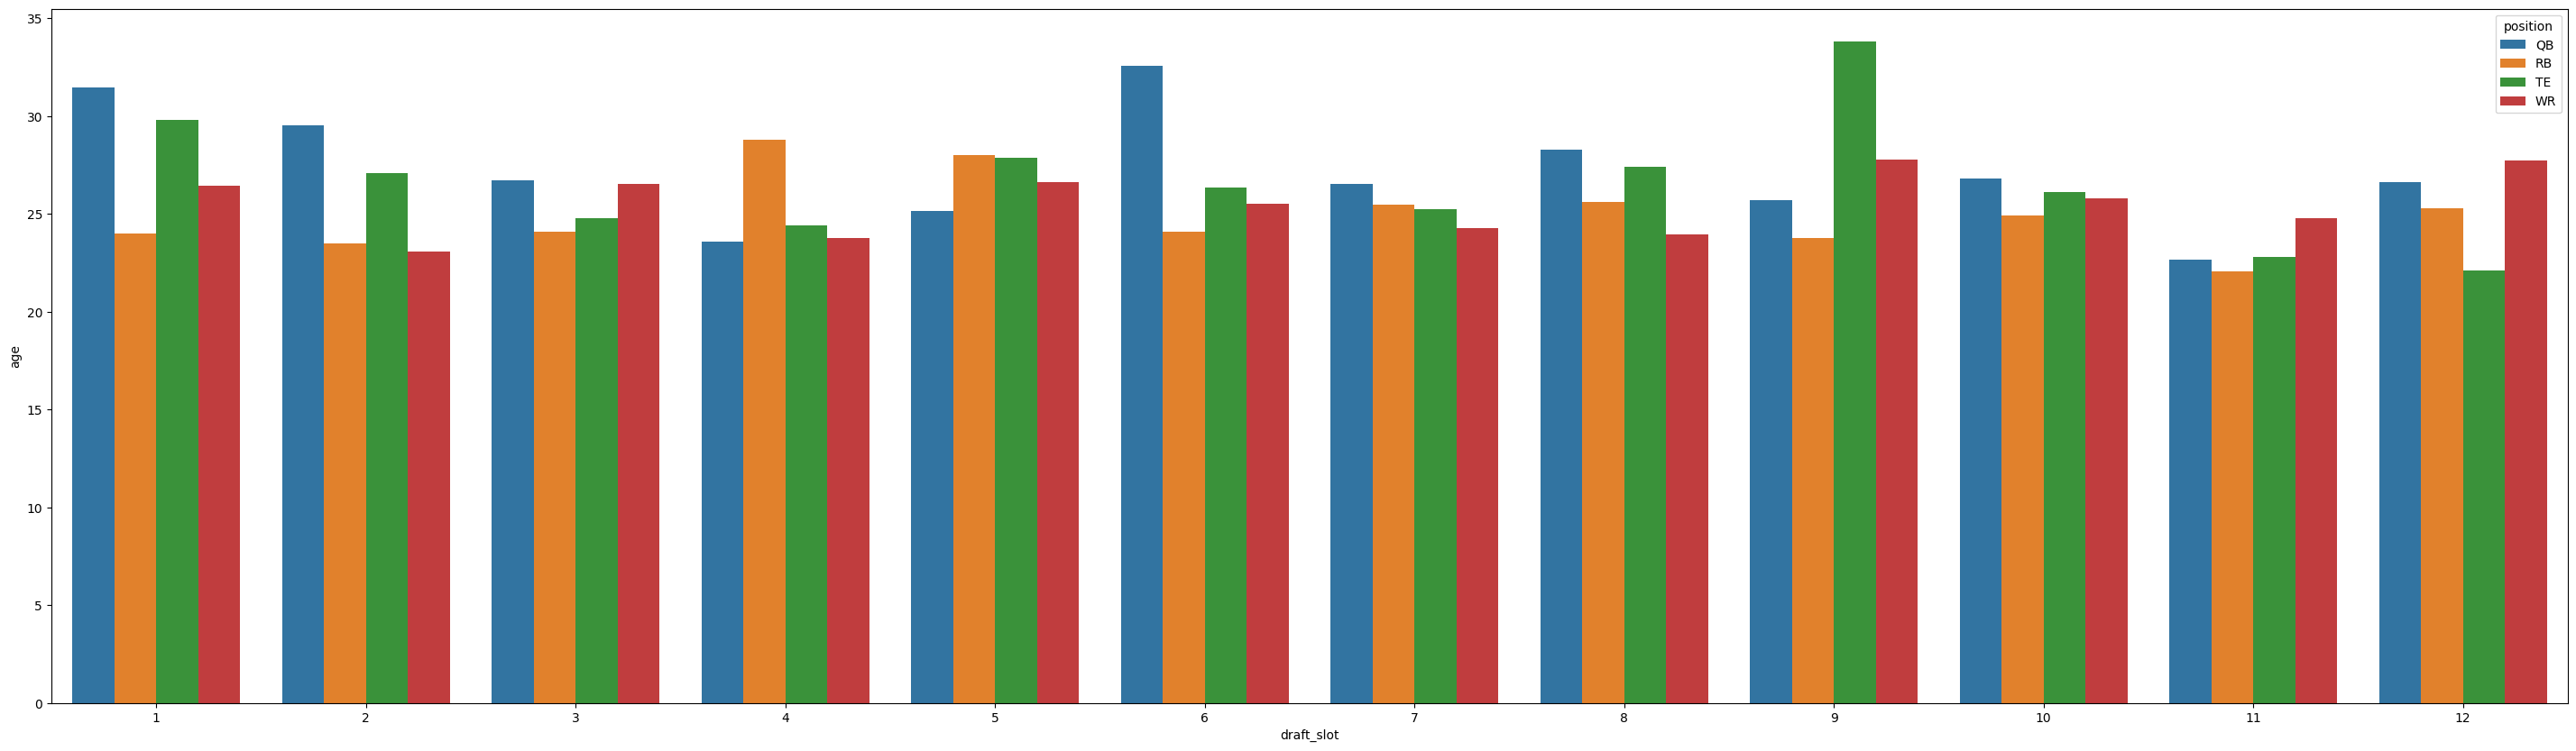

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x="draft_slot", y="age", hue="position", data=age_data)
plt.rcParams['figure.figsize'] = (36, 4)
plt.show()


# plt.barh(draft_grade_final["draft_slot"].astype(str).values, draft_grade_final["Tier"])
# plt.title("Average Tier of Drafted Players (Through 12 Rounds)")
# plt.ylabel("Draft Slot Number")
# plt.xlabel("Total Number of Picks")
# plt.show()

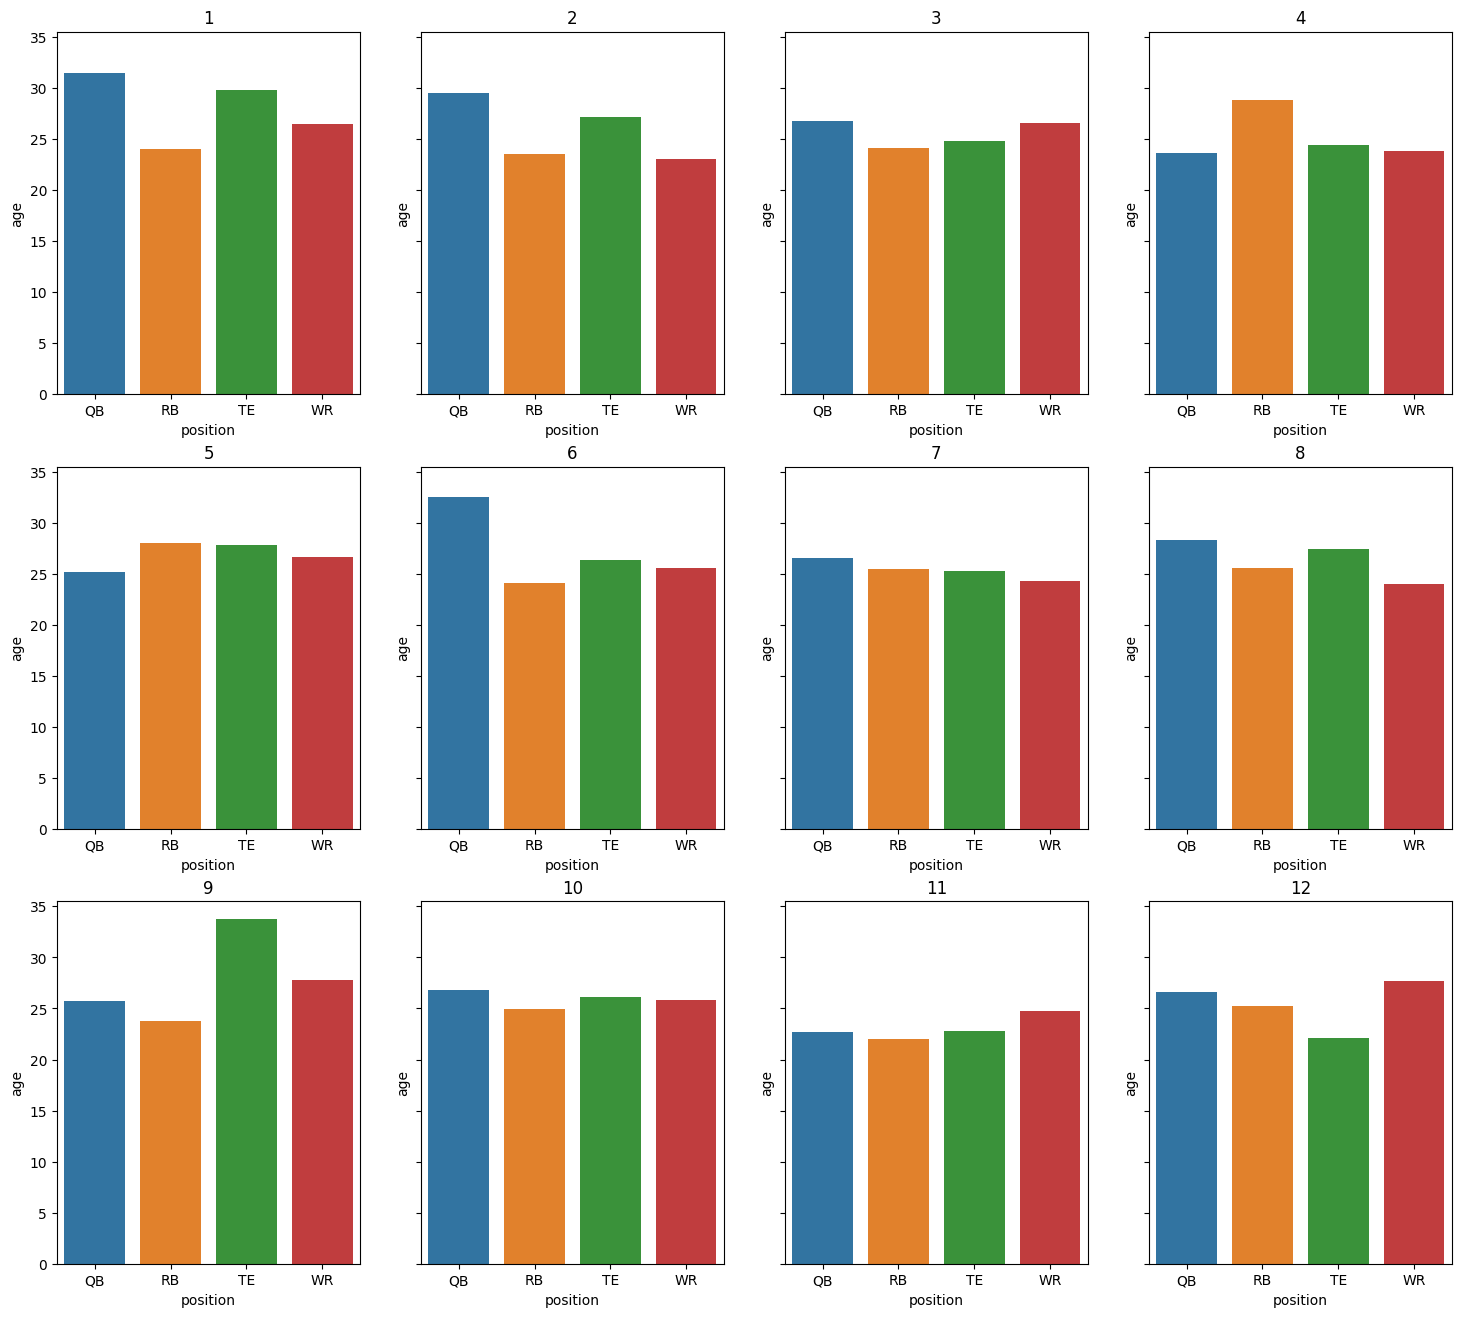

In [51]:
import numpy as np
fig, ax = plt.subplots(3, 4, sharey=True, figsize=(18,16))

for i in range(1, 13):
    age_data_filter = age_data[age_data["draft_slot"].astype(int) == i]   
    if i <= 4:
        ax[0, i-1].set_title(i)
        sns.barplot(ax=ax[0, i-1], x="position", y="age", data=age_data_filter)
    elif i > 4 and i <=8:
        ax[1, i-5].set_title(i)
        sns.barplot(ax=ax[1, i-5], x="position", y="age", data=age_data_filter)
    else:
        ax[2, i-9].set_title(i)
        sns.barplot(ax=ax[2, i-9], x="position", y="age", data=age_data_filter)


In [31]:
ax

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)